In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torchvision import models, transforms


import matplotlib.pyplot as plt
import random
import time
import os

import numpy as np


# mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

# unzip train, valid dataset
# target 을 정하지 않으면 google drive 내의 content 드라이브에 위치시킴
# 런타임을 다시 시작할 때 마다 unzip 을 새로 해주어야 함.
!unzip /content/gdrive/MyDrive/2023_EEE4178_project/train.zip
!unzip /content/gdrive/MyDrive/2023_EEE4178_project/valid.zip
# !unzip /content/gdrive/MyDrive/Project_dataset/Font_npy_100_test.zip

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: valid/49/1763_49.npy    
  inflating: valid/49/679_49.npy     
  inflating: valid/49/241_49.npy     
  inflating: valid/49/957_49.npy     
  inflating: valid/49/1154_49.npy    
  inflating: valid/49/584_49.npy     
  inflating: valid/49/1719_49.npy    
  inflating: valid/49/559_49.npy     
  inflating: valid/49/87_49.npy      
  inflating: valid/49/614_49.npy     
  inflating: valid/49/153_49.npy     
  inflating: valid/49/1170_49.npy    
  inflating: valid/49/996_49.npy     
  inflating: valid/49/1933_49.npy    
  inflating: valid/49/1268_49.npy    
  inflating: valid/49/63_49.npy      
  inflating: valid/49/823_49.npy     
  inflating: valid/49/492_49.npy     
  inflating: valid/49/811_49.npy     
  inflating: valid/49/602_49.npy     
  inflating: valid/49/958_49.npy     
  inflating: valid/49/222_49.npy     
  inflating: valid/49/1172_49.npy    
  inflating: valid/49/217_49.npy     
  inflating: valid/49/1240_49.npy    
  inflating: v

In [2]:
import os
import glob
import numpy as np
import torch
from torch.utils.data import Dataset
from torchvision import transforms
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF


class MyDataset(Dataset):
    def __init__(self, npy_dir, label_dict=None):
        self.dir_path = npy_dir
        self.to_tensor = transforms.Compose([
            transforms.ToTensor(),
            transforms.Lambda(lambda x: x.transpose(0, 1)),
            transforms.Lambda(lambda x: TF.rotate(x, -90))
        ])
        self.npy_path = glob.glob(os.path.join(npy_dir, '*', '*.npy'))
        self.label_dict = label_dict or self.create_label_dict()

    def create_label_dict(self):
        label_dict = {}
        for path in self.npy_path:
            label_name = os.path.basename(os.path.dirname(path))
            if label_name not in label_dict:
                label_dict[label_name] = len(label_dict)
        return label_dict

    def __getitem__(self, index):
        single_data_path = self.npy_path[index]
        data = np.load(single_data_path, allow_pickle=True)

        image = data['image']
        image = self.to_tensor(image)
        image = TF.hflip(image)

        label_name = os.path.basename(os.path.dirname(single_data_path))
        label = self.label_dict[label_name]
        label = torch.tensor(label, dtype=torch.long)

        return (image, label)

    def __len__(self):
        return len(self.npy_path)

label_dict = {
    '30': 0, '31': 1, '32': 2, '33': 3, '34': 4, '35': 5, '36': 6, '37': 7, '38': 8, '39': 9,
    '41': 10, '42': 11, '43': 12, '44': 13, '45': 14, '46': 15, '47': 16, '48': 17, '49': 18,
    '4a': 19, '4b': 20, '4c': 21, '4d': 22, '4e': 23, '50': 24, '51': 25, '52': 26, '53': 27,
    '54': 28, '55': 29, '56': 30, '57': 31, '58': 32, '59': 33, '5a': 34, '61': 35, '62': 36,
    '64': 37, '65': 38, '66': 39, '67': 40, '68': 41, '69': 42, '6a': 43, '6d': 44, '6e': 45,
    '6f': 46, '71': 47, '72': 48, '74': 49, '75': 50, '79': 51,
}



# unzip 한 디렉토리 있는 path 그대로 넣어야, 디렉토리 옆 점 3개 누르면 '경로 복사' 있음 - 위의 사진 참조
train_data = MyDataset("/content/train", label_dict)
valid_data = MyDataset("/content/valid", label_dict)

print(len(train_data))
print(len(valid_data))

41600
15600


In [3]:
batch_size = 200
train_loader = torch.utils.data.DataLoader(dataset=train_data,
                                           batch_size=batch_size,
                                           shuffle=True)

valid_loader = torch.utils.data.DataLoader(dataset=valid_data,
                                           batch_size=batch_size,
                                           shuffle=True)



# check dataloader
image,label = next(iter(valid_loader))
print(image.shape)
print(label.shape)

torch.Size([200, 1, 100, 100])
torch.Size([200])


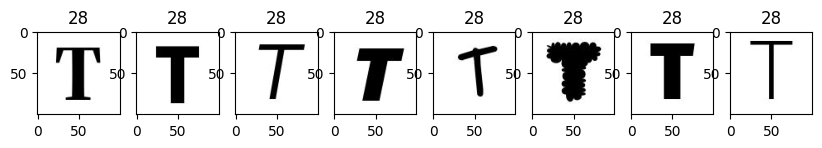

In [4]:
# visualize data
# image_show function : num 수 만큼 dataset 내의 data를 보여주는 함수
def image_show(dataset, num):
  fig = plt.figure(figsize=(10,10))

  for i in range(num):
    plt.subplot(1, num, i+1)
    plt.imshow(dataset[i+12200][0].squeeze(), cmap="gray")
    plt.title(dataset[i+12200][1].item())  # .item()을 사용하여 텐서에서 숫자로 변환

image_show(train_data, 8)

In [5]:
# device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')
!nvidia-smi

Sun Dec 24 14:35:02 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8              10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [6]:
# FIX SEED
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.deterministic = True  # type: ignore
    torch.backends.cudnn.benchmark = True  # type: ignore

seed_everything(42)

In [7]:
# hyper - parameters
num_classes = 52
input_size = 100
num_epochs = 13
learning_rate = 0.001 # 0.001
hidden_dim = 128
num_layers = 3
in_channel = 1
embedding_dim = 64 #64
dropout = 0.1
max_pool_kernel = 2

In [8]:
class CNN(nn.Module):
  def __init__(self, embedding_dim, hidden_dim, num_layers):
        super(CNN, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=2, stride=1),
            nn.BatchNorm2d(num_features=32),  # out_channels이 그대로 들어감
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.MaxPool2d(kernel_size=max_pool_kernel, stride = 2)  # 2 * 2
        )
        #nn.init.kaiming_normal_(self.layer1.weight, mode='fan_out', nonlinearity='relu')
        self.layer1.apply(self._init_weights)
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding = 2, stride = 2),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.MaxPool2d(kernel_size=max_pool_kernel, stride = 2)
        )
        #nn.init.kaiming_normal_(self.layer2.weight, mode='fan_out', nonlinearity='relu')
        self.layer2.apply(self._init_weights)
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size = 3, stride = 2, padding = 2),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.MaxPool2d(kernel_size=max_pool_kernel)
        )
        #nn.init.kaiming_normal_(self.layer3.weight, mode='fan_out', nonlinearity='relu')
        self.layer3.apply(self._init_weights)
        self.layer4 = nn.Sequential(
            nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = 3, stride = 1, padding = 2),
            nn.BatchNorm2d(num_features = 256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.MaxPool2d(kernel_size=max_pool_kernel)
        )
        self.layer4.apply(self._init_weights)
        #nn.init.kaiming_normal_(self.layer4.weight, mode='fan_out', nonlinearity='relu')
        self.layer5 = nn.Sequential(
            nn.Conv2d(in_channels = 256, out_channels = 512, kernel_size = 2, stride = 1, padding = 2),
            nn.BatchNorm2d(num_features = 512),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.MaxPool2d(kernel_size=max_pool_kernel)
        )
        #nn.init.kaiming_normal_(self.layer5.weight, mode='fan_out', nonlinearity='relu')
        # fully - connected
        self.fc1 = nn.Linear(in_features=2304, out_features=256)
        nn.init.kaiming_normal_(self.fc1.weight, mode='fan_out', nonlinearity='relu')
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        nn.init.kaiming_normal_(self.fc2.weight, mode='fan_out', nonlinearity='relu')
        #self.dropout1 = nn.Dropout(p=0.25, inplace=False)
        self.fc3 = nn.Linear(in_features=128, out_features=num_classes)

        self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout)


  def _init_weights(self, m):
        if isinstance(m, nn.Conv2d):
          nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')

  def forward(self, x):
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)

    #x = x.reshape(x.size(0), -1, embedding_dim)

    #x, _ = self.lstm(x)

    x = x.reshape(x.size(0), -1)  # fully connected에 넣어주기 위해서 flatten 시켜주기

    x = self.fc1(x)
    #x = self.dropout(x)
    x = F.relu(x)
    x = self.fc2(x)
    #x = self.dropout(x)
    x = F.relu(x)
    x = self.fc3(x)

    return x  # 10개의 출력 return

In [9]:
model = CNN(embedding_dim, hidden_dim, num_layers).to(device)

criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

total_step = len(train_loader)
loss_list = []

In [11]:

start = time.time()
model.train()
for epoch in range(num_epochs):
  for i, (image, label) in enumerate(train_loader):
    image = image.to(device)
    label = label.to(device)

    output = model(image)
    loss = criterion(output, label)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    loss_list.append(loss.item())

    print("Epoch [{}/{}], Step[{}/{}], Loss:{:.4f}".format(epoch+1, num_epochs, i+1, total_step, loss.item()))

torch.save(model.state_dict(), "20191611.pth")
end = time.time()
duration = end-start
print("Training takes {:.2f}minutes".format(duration/60))

Epoch [1/13], Step[1/208], Loss:8.7928
Epoch [1/13], Step[2/208], Loss:6.7266
Epoch [1/13], Step[3/208], Loss:5.4359
Epoch [1/13], Step[4/208], Loss:4.7889
Epoch [1/13], Step[5/208], Loss:4.6517
Epoch [1/13], Step[6/208], Loss:4.5117
Epoch [1/13], Step[7/208], Loss:4.2745
Epoch [1/13], Step[8/208], Loss:4.1041
Epoch [1/13], Step[9/208], Loss:4.1369
Epoch [1/13], Step[10/208], Loss:3.9831
Epoch [1/13], Step[11/208], Loss:3.8625
Epoch [1/13], Step[12/208], Loss:3.9379
Epoch [1/13], Step[13/208], Loss:3.8771
Epoch [1/13], Step[14/208], Loss:3.8225
Epoch [1/13], Step[15/208], Loss:3.8675
Epoch [1/13], Step[16/208], Loss:3.7659
Epoch [1/13], Step[17/208], Loss:3.6341
Epoch [1/13], Step[18/208], Loss:3.7351
Epoch [1/13], Step[19/208], Loss:3.5796
Epoch [1/13], Step[20/208], Loss:3.5809
Epoch [1/13], Step[21/208], Loss:3.4344
Epoch [1/13], Step[22/208], Loss:3.5144
Epoch [1/13], Step[23/208], Loss:3.5571
Epoch [1/13], Step[24/208], Loss:3.5391
Epoch [1/13], Step[25/208], Loss:3.4815
Epoch [1/

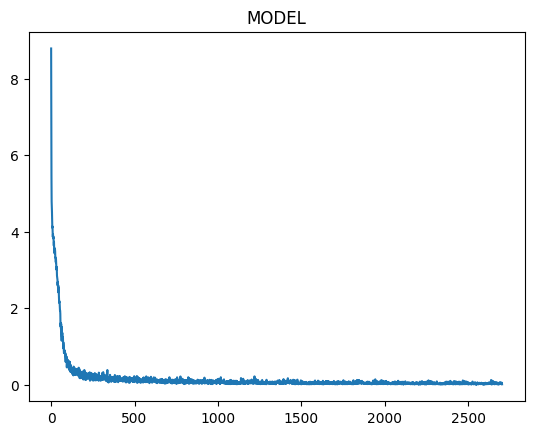

In [12]:
plt.plot(loss_list)
plt.title("MODEL")
plt.show()

In [13]:
# Print the summary
from torchsummary import summary
#from torchinfo import summary
summary(model, (1, 100, 100))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 102, 102]             320
       BatchNorm2d-2         [-1, 32, 102, 102]              64
              ReLU-3         [-1, 32, 102, 102]               0
           Dropout-4         [-1, 32, 102, 102]               0
         MaxPool2d-5           [-1, 32, 51, 51]               0
            Conv2d-6           [-1, 64, 26, 26]          51,264
       BatchNorm2d-7           [-1, 64, 26, 26]             128
              ReLU-8           [-1, 64, 26, 26]               0
           Dropout-9           [-1, 64, 26, 26]               0
        MaxPool2d-10           [-1, 64, 13, 13]               0
           Conv2d-11            [-1, 128, 8, 8]          73,856
      BatchNorm2d-12            [-1, 128, 8, 8]             256
             ReLU-13            [-1, 128, 8, 8]               0
          Dropout-14            [-1, 12

In [12]:

model.load_state_dict(torch.load('./20191611.pth'))
model.eval()
with torch.no_grad():
  correct = 0

  for image, label in valid_loader:
    image = image.to(device)
    label = label.to(device)
    output = model(image)
    _ , pred = torch.max(output.data, 1)
    correct += (pred == label).sum().item()

  print('Accuracy of the last_model network on the {} valid images: {} %'.format(len(valid_data), 100 * correct / len(valid_data)))

Accuracy of the last_model network on the 15600 valid images: 98.23717948717949 %
